In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold


import xgboost as xgb
import warnings
import joblib
import boto3
import sagemaker
import os
import warnings
from scipy.stats import boxcox

warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
#Loading the dataset
data_df = pd.read_excel('AnomaData.xlsx')

In [5]:
data_df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x54,x55,x56,x57,x58,x59,x60,y.1
0,1999-05-01 00:00:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,1999-05-01 00:02:00,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,1999-05-01 00:04:00,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,1999-05-01 00:06:00,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,1999-05-01 00:08:00,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [6]:
data_df.shape

(18398, 62)

In [7]:
# Get an overview of the dataset
print("\nDataset overview:")
data_df.info()


Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    18398 non-null  datetime64[ns]
 1   y       18398 non-null  int64         
 2   x1      18398 non-null  float64       
 3   x2      18398 non-null  float64       
 4   x3      18398 non-null  float64       
 5   x4      18398 non-null  float64       
 6   x5      18398 non-null  float64       
 7   x6      18398 non-null  float64       
 8   x7      18398 non-null  float64       
 9   x8      18398 non-null  float64       
 10  x9      18398 non-null  float64       
 11  x10     18398 non-null  float64       
 12  x11     18398 non-null  float64       
 13  x12     18398 non-null  float64       
 14  x13     18398 non-null  float64       
 15  x14     18398 non-null  float64       
 16  x15     18398 non-null  float64       
 17  x16     18398 non-null  float64

In [8]:
# Descriptive statistics of numerical features
print("\nDescriptive statistics of numerical features:")
data_df.describe()


Descriptive statistics of numerical features:


,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x54,x55,x56,x57,x58,x59,x60,y.1
count,18398,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,...,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000
mean,1999-05-15 01:20:42.728557312,0.006740,0.011824,0.157986,0.569300,-9.958345,0.006518,2.387533,0.001647,-0.004125,...,-3.357339,0.380519,0.173708,2.379154,9.234953,0.233493,-0.001861,-0.061522,0.001258,0.001033
min,1999-05-01 00:00:00,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,...,-3652.989000,-187.943440,-8.210370,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.012229,0.000000
25%,1999-05-08 03:36:30,0.000000,-0.405681,-2.158235,-3.537054,-111.378372,-0.446787,-24.345268,-0.058520,-0.051043,...,29.984624,-3.672684,0.487780,-40.050046,-45.519149,-1.598804,0.000470,0.295023,-0.001805,0.000000
50%,1999-05-14 18:39:00,0.000000,0.128245,-0.075505,-0.190683,-14.881585,-0.120745,10.528435,-0.009338,-0.000993,...,29.984624,0.294846,0.702299,17.471317,1.438806,0.085826,0.012888,0.734591,0.000710,0.000000
75%,1999-05-22 06:01:30,0.000000,0.421222,2.319297,3.421223,92.199134,0.325152,32.172974,0.060515,0.038986,...,29.984624,5.109543,2.675751,44.093387,63.209681,2.222118,0.020991,1.266506,0.004087,0.000000
max,1999-05-29 00:06:00,1.000000,3.054156,16.742105,15.900116,334.694098,4.239385,96.060768,1.705590,0.788826,...,40.152348,14.180588,6.637265,287.252017,252.147455,6.922008,0.067249,6.985460,0.020510,1.000000
std,NaN,0.081822,0.742875,4.939762,5.937178,131.033712,0.634054,37.104012,0.108870,0.075460,...,348.256716,6.211598,3.029516,67.940694,81.274103,2.326838,0.048732,10.394085,0.004721,0.032120


In [9]:
# Check for missing values
print("\nMissing values in the dataset:")
data_df.isnull().sum()


Missing values in the dataset:


time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64

In [10]:
# No missing values found in the data 

In [11]:
# Count the number of rows where 'y' has a value of 1(Anomalies)
count_y = (data_df['y'] == 1).sum()
print("Number of rows where y has a value of 1:", count_y)

Number of rows where y has a value of 1: 124


In [12]:
# Count the number of rows where 'y.1' has a value of 1(Anomalies)
count_y1 = (data_df['y.1'] == 1).sum()
print("Number of rows where y.1 has a value of 1:", count_y1)

Number of rows where y.1 has a value of 1: 19


In [13]:
# Visuals to understand the data

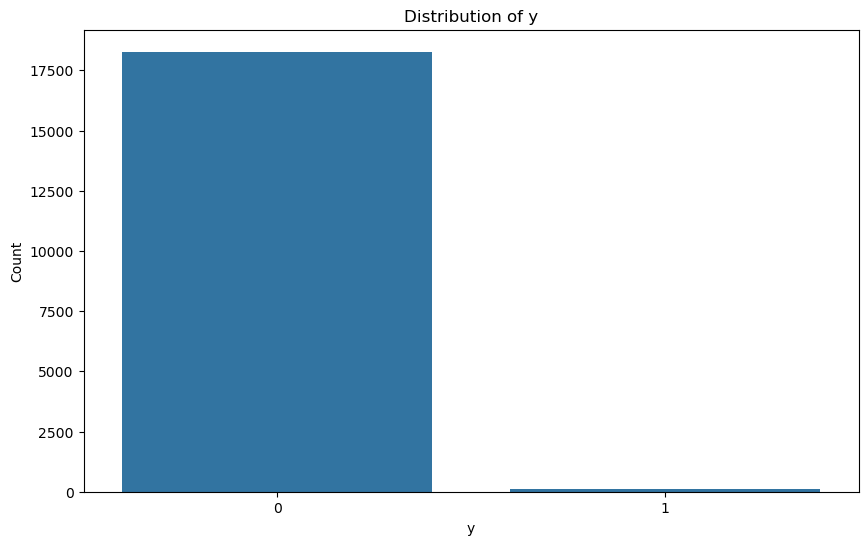

In [14]:
# Plot the distribution of 'y'
plt.figure(figsize=(10, 6))
sns.countplot(x='y', data=data_df)
plt.title('Distribution of y')
plt.xlabel('y')
plt.ylabel('Count')
plt.show()

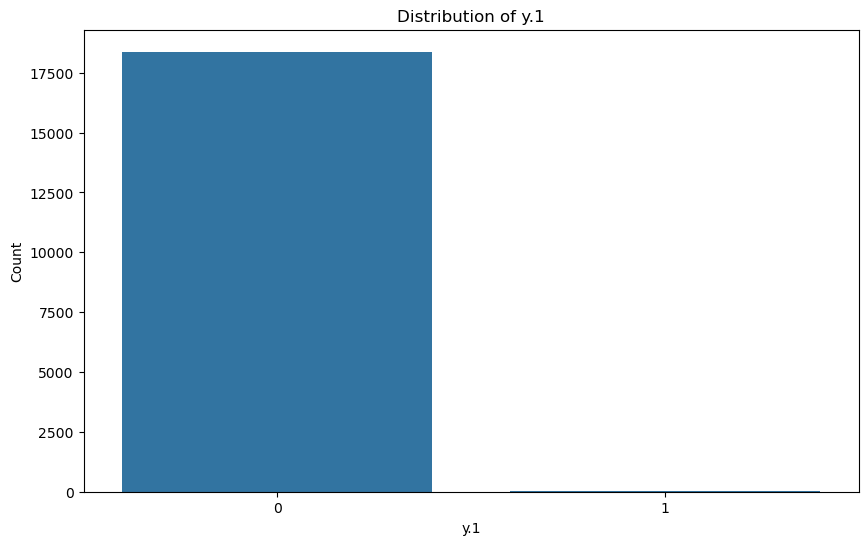

In [15]:
# Plot the distribution of 'y.1'
plt.figure(figsize=(10, 6))
sns.countplot(x='y.1', data=data_df)
plt.title('Distribution of y.1')
plt.xlabel('y.1')
plt.ylabel('Count')
plt.show()

In [16]:
# Check for discrepancies between 'y' and 'y.1'
discrepancies = (data_df['y'] != data_df['y.1']).sum()
print("Number of discrepancies between y and y.1:", discrepancies)

Number of discrepancies between y and y.1: 105


In [17]:
# Identify rows where 'y' and 'y.1' values differ
discrepancy_indices = data_df[data_df['y'] != data_df['y.1']].index

# Display the rows with discrepancies
discrepancies_df = data_df.loc[discrepancy_indices]
print("Rows with discrepancies between y and y.1:")
discrepancies_df

Rows with discrepancies between y and y.1:


,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x54,x55,x56,x57,x58,x59,x60,y.1
776,1999-05-02 04:02:00,1,-0.782471,-12.118747,-16.855194,-322.781610,-0.738810,25.966042,0.040711,-0.071186,...,29.984624,0.324387,2.680329,-7.209775,-37.195777,1.642284,0.013798,2.664362,0.007856,0
835,1999-05-02 06:24:00,1,-0.697450,-1.696176,4.145142,121.152838,-0.598597,-7.789024,0.060853,0.048752,...,29.984624,-1.685379,2.568616,-26.245907,-74.477362,-0.097279,0.015905,2.700281,0.007745,0
1036,1999-05-02 13:08:00,1,-0.791718,-0.076644,-1.012134,162.257269,-0.062876,9.005471,0.005767,0.033764,...,29.984624,-2.757156,2.703874,-29.833432,-53.421866,-1.165393,0.019691,3.348276,0.006241,0
1263,1999-05-02 20:42:00,1,-1.212082,-2.326809,0.922287,31.935858,-0.920100,14.183205,-0.089298,0.028915,...,29.984624,-2.757156,2.762956,0.965763,-49.512961,-0.219349,0.041640,2.740404,0.005131,0
1301,1999-05-02 22:02:00,1,-1.096000,-13.684237,-14.116964,-56.283533,-0.455286,1.637367,-0.088821,0.048752,...,29.984624,-2.757156,2.795432,9.664615,-57.170462,-1.429005,0.049915,2.801676,0.005420,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17476,1999-05-27 16:22:00,1,-0.041754,-5.962647,-6.051125,80.112647,-0.432002,59.951271,-0.039246,0.008773,...,29.984624,-2.640213,1.509405,78.040348,88.722436,-0.860218,0.008104,0.347758,-0.006652,0
17605,1999-05-27 21:12:00,1,0.105436,3.501577,4.891846,67.102515,0.497060,45.304116,-0.049319,0.088731,...,29.984624,-1.903641,1.332608,88.117984,75.932031,-1.470630,0.010403,0.907999,-0.006908,0
17866,1999-05-28 05:54:00,1,0.231069,1.183568,1.780737,74.636116,-0.406168,53.183663,-0.109134,-0.041277,...,28.824956,-1.689041,1.396549,69.665592,82.686090,-0.616077,0.018050,1.120821,-0.005341,0
17893,1999-05-28 06:50:00,1,0.075007,-13.796615,-16.995079,177.938849,-0.240000,57.281533,-0.009338,-0.000993,...,28.596929,-1.689041,2.452444,80.604312,-19.472189,-1.226490,0.014139,0.717982,-0.005746,0


In [18]:
# Filter the DataFrame to get rows where 'y.1' has the value 1
data_y1_anomalies = data_df[data_df['y.1'] == 1]

# Display the data where 'y.1' has anomalies
print("Data where 'y.1' has anomalies:")
data_y1_anomalies

Data where 'y.1' has anomalies:


,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x54,x55,x56,x57,x58,x59,x60,y.1
259,1999-05-01 08:38:00,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,...,29.984624,11.280929,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663,1
2308,1999-05-04 12:58:00,1,-0.525188,-8.807990,-9.835420,-59.513696,0.291692,-40.433449,0.300729,0.148853,...,28.317387,-6.593094,-4.976071,-28.315610,-33.812338,-0.860218,-0.012435,3.536661,0.005474,1
2312,1999-05-04 13:42:00,1,-0.245098,-8.875781,-9.638067,-92.129571,0.807394,-54.874000,0.341229,0.128711,...,28.496343,-5.085281,-4.871771,-26.151913,-48.465994,-9.645008,-0.012185,3.288340,0.005792,1
2317,1999-05-04 14:40:00,1,-0.411052,-8.826300,-9.723619,-99.466882,0.235036,-60.351768,0.380687,0.168995,...,28.732427,-3.463944,-4.903809,-5.086484,-52.971655,0.696178,-0.003202,3.828463,0.006212,1
2335,1999-05-04 15:46:00,1,-0.671767,-8.833014,-9.729623,-81.845605,0.292409,-58.457481,0.040711,0.068894,...,29.000981,-2.642410,-4.940266,-23.400448,-51.868781,0.391002,0.002447,2.792513,0.006689,1
2407,1999-05-04 20:44:00,1,0.543477,-8.863991,-9.704750,-63.614374,-0.017481,-57.305717,0.040711,-0.071186,...,29.984624,-0.856033,-4.999060,-59.115536,-50.999381,2.863048,0.028032,2.953348,0.007756,1
7173,1999-05-11 19:06:00,1,0.626861,-8.975841,-9.826181,-181.902060,-0.709605,-55.156898,0.080690,-0.011064,...,29.984624,10.186691,0.566448,48.454898,16.143762,4.175304,0.023567,0.105669,-0.004327,1
9412,1999-05-15 01:56:00,1,0.408017,-8.807990,-9.821728,266.862860,-0.293864,34.117958,-0.039246,-0.091023,...,29.984624,-14.760330,-5.072882,-75.662655,77.682275,1.569042,0.020328,-0.117727,-0.000525,1
10241,1999-05-16 07:22:00,1,0.386066,-9.029249,-8.759439,83.883704,-0.509745,52.357521,0.180791,0.268791,...,29.984624,-4.876541,3.143712,18.257755,-72.250327,-1.775807,-0.149790,-0.102720,0.000803,1
10798,1999-05-17 02:50:00,1,-0.606869,-8.807990,-9.638677,-79.248254,-0.388133,-33.339103,0.390758,-0.041277,...,28.051762,2.990890,0.586952,121.800601,-49.955710,0.085826,-0.149790,0.636728,0.000922,1


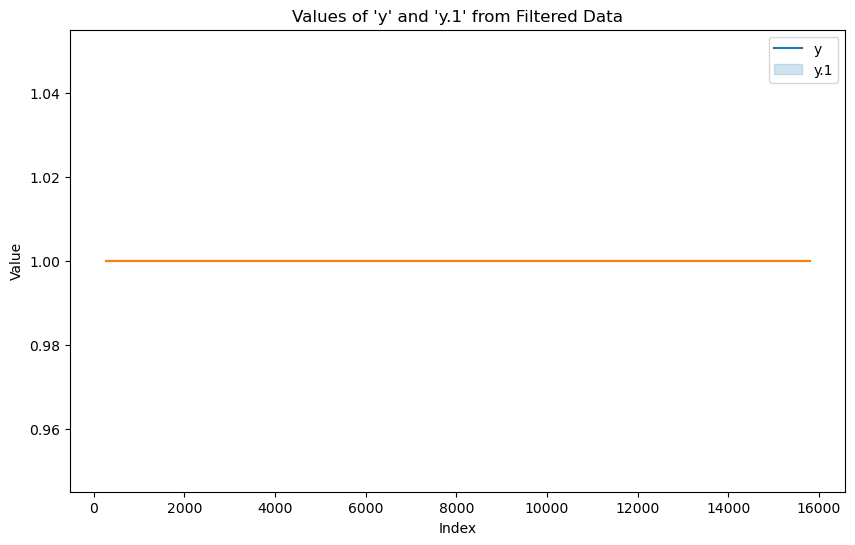

In [19]:
# Plot the values of 'y' and 'y.1' from the filtered data
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_y1_anomalies[['y', 'y.1']], dashes=False)
plt.title("Values of 'y' and 'y.1' from Filtered Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(['y', 'y.1'])
plt.show()

In [20]:
# Since the column y.1 has the only 19 anomalies and all the 19 anomalies are already present in the column y.
# this makes the column y.1 redundant as it does not add any value to the data.
# Based on the above analysis, deleting the column y.1

# Drop the 'y.1' column from the DataFrame
data_df.drop(columns=['y.1'], inplace=True)

# Verify that the 'y.1' column has been deleted
print("Columns after deletion:", data_df.columns)

Columns after deletion: Index(['time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60'],
      dtype='object')


In [21]:
data_df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x50,x51,x52,x54,x55,x56,x57,x58,x59,x60
0,1999-05-01 00:00:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,11.295155,29.984624,10.091721,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,1999-05-01 00:02:00,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,11.290761,29.984624,10.095871,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,1999-05-01 00:04:00,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,11.286366,29.984624,10.100265,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,1999-05-01 00:06:00,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,11.281972,29.984624,10.104660,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,1999-05-01 00:08:00,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,11.277577,29.984624,10.109054,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


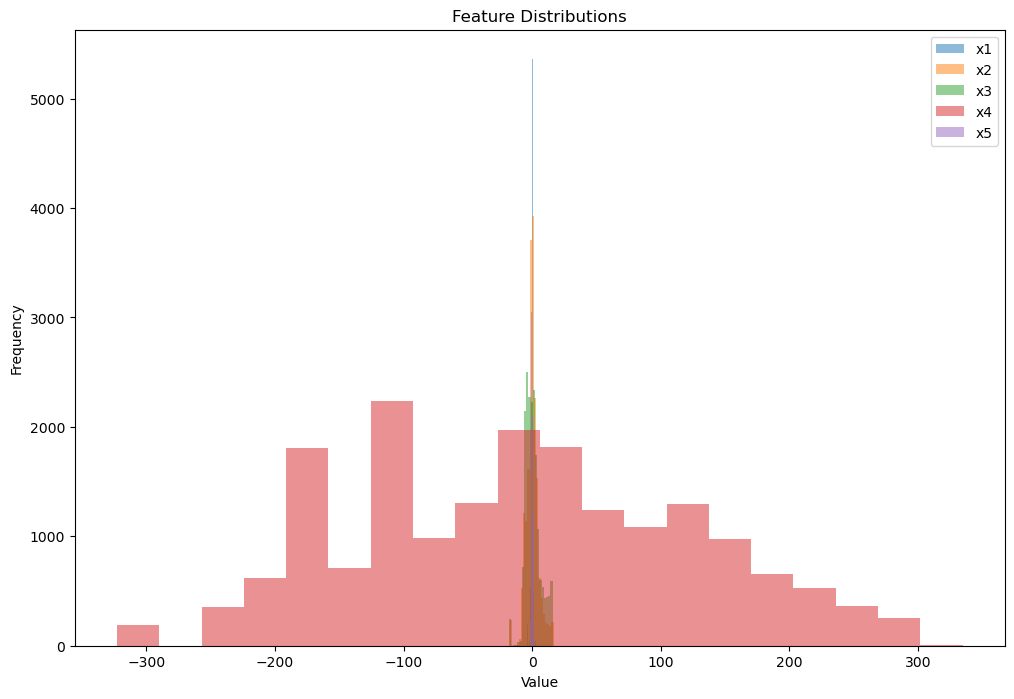

In [22]:
# Selecting a subset of features for visualization
selected_features = ['x1', 'x2', 'x3', 'x4', 'x5']

# Feature Distributions (Histograms)
plt.figure(figsize=(12, 8))
for feature in selected_features:
    plt.hist(data_df[feature], bins=20, alpha=0.5, label=feature)

plt.title("Feature Distributions")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

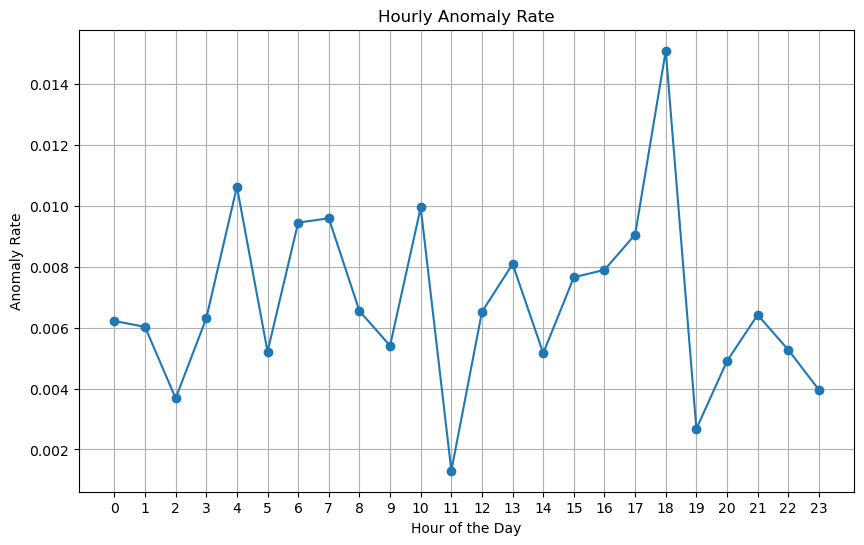

In [23]:
# Aggregate data based on time intervals (e.g., hours)
hourly_data = data_df.groupby(data_df['time'].dt.hour)['y'].mean()

# Visualize the relationship between time and anomalies
plt.figure(figsize=(10, 6))
hourly_data.plot(kind='line', marker='o')
plt.title('Hourly Anomaly Rate')
plt.xlabel('Hour of the Day')
plt.ylabel('Anomaly Rate')
plt.xticks(range(24))  # Set x-axis ticks to show all hours
plt.grid(True)
plt.show()

In [24]:
# Identify numerical columns excluding datetime and target 'y' column
numerical_columns = data_df.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop(['y'])

# Compute skewness for each numerical feature
skewness = data_df[numerical_columns].apply(lambda x: x.skew())

# Display skewness for each numerical feature
print("Skewness for each numerical feature:")
print(skewness)

Skewness for each numerical feature:
x1     -1.247727
x2      0.246201
x3      0.405579
x4      0.125157
x5      0.683805
x6     -0.778422
x7      2.435930
x8     -1.602778
x9      9.013223
x10     8.944292
x11    -7.186179
x12    -8.361979
x13    -0.123806
x14    10.143996
x15     7.491856
x16    -7.890303
x17     0.876826
x18     0.619385
x19   -14.644107
x20    -1.203704
x21     0.255382
x22     0.580391
x23    -3.142078
x24     0.554978
x25    -9.499579
x26     0.706270
x27    -1.097334
x28     0.869126
x29    -0.314435
x30    -0.384328
x31    -0.063506
x32    -9.616123
x33     0.274189
x34    -0.742769
x35    -0.053339
x36     4.797030
x37    -2.020053
x38     9.852337
x39     3.771112
x40    -4.413802
x41     0.294298
x42     1.512382
x43     7.523149
x44    -0.751970
x45     9.146000
x46     2.085610
x47    -0.977718
x48    -1.809828
x49    -0.413468
x50     0.239725
x51   -10.385342
x52    -1.307843
x54    -0.931539
x55    -0.460709
x56     0.525338
x57     0.203035
x58    -2.4

In [25]:

# Select numerical features (excluding the target variable 'y')
numerical_features = data_df.drop(columns=['y']).select_dtypes(include=['number'])

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the numerical features in the original DataFrame
data_df[numerical_features.columns] = scaler.fit_transform(numerical_features)

# Initialize PowerTransformer for Yeo-Johnson transformation
transformer = PowerTransformer(method='yeo-johnson')

# Transform the skewed features using Yeo-Johnson transformation
data_df[numerical_features.columns] = transformer.fit_transform(data_df[numerical_features.columns])

# Display the first few rows of the transformed DataFrame
print("Transformed Data:")
data_df.head()

Transformed Data:


,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x50,x51,x52,x54,x55,x56,x57,x58,x59,x60
0,1999-05-01 00:00:00,0,0.444909,-0.969031,-0.777772,0.211426,-0.039593,-0.783787,0.053123,-0.800893,...,1.560447,0.128729,1.588546,-1.47195,-0.485930,0.212577,1.345074,1.547213,-0.079219,1.022860
1,1999-05-01 00:02:00,0,0.603809,-0.957386,-0.762755,0.231978,-0.057469,-0.743023,0.053123,-0.800893,...,1.559886,0.128729,1.589244,-1.47204,-0.590901,0.263820,1.050286,1.555629,0.021579,1.024170
2,1999-05-01 00:04:00,0,0.424659,-0.987387,-0.827887,0.216169,-0.075459,-0.723080,0.147831,-0.800893,...,1.559325,0.128729,1.589982,-1.47213,-0.614329,0.314425,1.368622,1.564153,0.630072,1.025479
3,1999-05-01 00:06:00,0,0.327342,-1.004153,-0.763773,0.208896,-0.092836,-0.737838,0.065852,-0.800893,...,1.558764,0.128729,1.590721,-1.47222,-0.637643,0.250752,1.532120,1.572601,1.307201,1.026788
4,1999-05-01 00:08:00,0,0.271864,-1.002205,-0.823984,0.224738,-0.106015,-0.715874,0.053123,-0.800893,...,1.558203,0.128729,1.591459,-1.47231,-0.660843,0.253577,1.392122,1.577752,0.268983,1.028283


In [26]:
# Checking skewness after transforming data
numerical_columns = data_df.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop(['y'])

skewness = data_df[numerical_columns].apply(lambda x: x.skew())

print("Skewness for each numerical feature:")
print(skewness)

Skewness for each numerical feature:
x1     0.191519
x2    -0.105665
x3    -0.192983
x4     0.002751
x5    -0.009701
x6    -0.084151
x7     0.031214
x8     0.292043
x9    -0.043161
x10   -0.045475
x11    0.504707
x12    0.253888
x13   -0.014435
x14    1.920119
x15    0.970454
x16    0.167712
x17   -0.583965
x18   -0.729425
x19    1.059138
x20    7.451187
x21   -0.044829
x22    0.003136
x23   -1.053178
x24    0.436592
x25   -0.110975
x26    0.045287
x27   -0.139652
x28    0.006046
x29    0.071904
x30    0.570471
x31   -0.013099
x32   -0.358725
x33    0.110332
x34   -0.084736
x35    0.001171
x36   -0.002522
x37   -0.120144
x38    0.165641
x39    0.132091
x40   -0.036676
x41   -0.010445
x42    0.585055
x43    3.759789
x44   -0.131627
x45   -0.139544
x46   -0.051993
x47   -0.168027
x48    0.342126
x49    0.129570
x50   -0.078846
x51   -5.349036
x52   -0.834656
x54   -0.211284
x55    0.046411
x56    0.004903
x57    0.027866
x58    0.226411
x59    0.958079
x60   -0.037963
dtype: float64


In [27]:
# Drop datetime columns from the feature matrix
datetime_columns = ['time']  # Replace 'time' with actual datetime column name(s) if different
X = data_df.drop(columns=['y'] + datetime_columns)

# Define the target variable
y = data_df['y']

# Define the estimator (model) for feature selection
estimator = LogisticRegression()

# Define the number of features to select (you can adjust this based on your requirements)
n_features_to_select = 30

# Initialize RFE
rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)

# Fit RFE to the transformed features
rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]

# Display the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['x2', 'x3', 'x5', 'x7', 'x8', 'x11', 'x16', 'x18', 'x21', 'x22', 'x25',
       'x26', 'x28', 'x29', 'x32', 'x33', 'x34', 'x36', 'x39', 'x42', 'x44',
       'x45', 'x47', 'x49', 'x51', 'x52', 'x55', 'x56', 'x57', 'x60'],
      dtype='object')


In [28]:
# Concatenate the time column and the selected features for the original DataFrame
final_df = data_df[selected_features].copy()
final_df['time'] = data_df['time']

# Add the 'y' column to the final DataFrame
final_df['y'] = data_df['y']


In [29]:

final_df['hour'] = final_df['time'].dt.hour
final_df['day_of_week'] = final_df['time'].dt.dayofweek
final_df['day_of_month'] = final_df['time'].dt.day


# Drop the original 'time' column
final_df.drop(columns=['time'], inplace=True)

In [30]:
final_df.shape

(18398, 34)

In [31]:
final_df.head()

,x2,x3,x5,x7,x8,x11,x16,x18,x21,x22,...,x51,x52,x55,x56,x57,x60,y,hour,day_of_week,day_of_month
0,-0.969031,-0.777772,-0.039593,0.053123,-0.800893,0.373446,-0.109443,-0.474860,-0.098086,-0.584314,...,0.128729,1.588546,-0.485930,0.212577,1.345074,1.022860,0,0,5,1
1,-0.957386,-0.762755,-0.057469,0.053123,-0.800893,0.368802,0.048812,-0.472236,-0.098086,-0.590884,...,0.128729,1.589244,-0.590901,0.263820,1.050286,1.024170,0,0,5,1
2,-0.987387,-0.827887,-0.075459,0.147831,-0.800893,0.502367,-0.030640,-0.469615,-0.098086,-0.597465,...,0.128729,1.589982,-0.614329,0.314425,1.368622,1.025479,0,0,5,1
3,-1.004153,-0.763773,-0.092836,0.065852,-0.800893,0.425663,-0.286800,-0.466994,-0.098086,-0.604056,...,0.128729,1.590721,-0.637643,0.250752,1.532120,1.026788,0,0,5,1
4,-1.002205,-0.823984,-0.106015,0.053123,-0.800893,0.324646,-0.151191,-0.464374,-0.098086,-0.610654,...,0.128729,1.591459,-0.660843,0.253577,1.392122,1.028283,0,0,5,1


In [32]:
# Calculate class distribution
class_distribution = final_df['y'].value_counts()

# Print class distribution
print("Class Distribution:")
print(class_distribution)

# class destribution is imbalanced

Class Distribution:
y
0    18274
1      124
Name: count, dtype: int64


In [33]:
# Define features (X) and target variable (y)
X = final_df.drop(columns=['y'])  # Exclude 'y' columns
y = final_df['y']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)







In [34]:
from imblearn.over_sampling import SMOTE

# Instantiate the SMOTE oversampler
oversampler = SMOTE(random_state=42)

# Resample the training data
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

# Print the class distribution after oversampling
print("Class Distribution after Oversampling:")
print(y_resampled.value_counts())

Class Distribution after Oversampling:
y
0    14616
1    14616
Name: count, dtype: int64


In [35]:

train_df = pd.concat([y_resampled, X_resampled], axis=1)
test_df = pd.concat([y_test, X_test ], axis=1)

In [36]:
train_df

,y,x2,x3,x5,x7,x8,x11,x16,x18,x21,...,x49,x51,x52,x55,x56,x57,x60,hour,day_of_week,day_of_month
0,0,-1.059947,0.315343,-0.917683,-0.646852,-0.800893,-0.737268,-1.375677,-0.717859,-0.098086,...,-0.276950,0.128729,0.094590,-1.245498,-0.647051,0.526178,1.300364,3,6,2
1,0,1.053050,1.403402,-1.172627,0.509258,-0.678227,-0.569989,1.730504,-0.717859,-1.740084,...,0.138902,0.128729,-0.464067,-0.668355,-0.250703,-0.131582,1.651005,8,4,7
2,0,-0.400020,0.180449,-0.537679,-0.545099,0.109020,-0.657272,2.757887,-0.948922,-0.098086,...,0.002249,0.128729,-0.516467,-0.668645,-0.851646,-0.423227,0.791717,18,6,2
3,0,0.336779,0.383917,-1.974430,-0.043308,0.254081,2.093224,1.970271,-0.387229,-0.098086,...,1.138736,0.128729,2.136925,2.087953,0.550978,1.232241,0.318072,1,6,9
4,0,-0.122625,0.078682,1.139398,0.255835,0.861465,-0.660253,0.840495,1.189885,0.339166,...,-1.886246,0.128729,-1.248946,-0.257091,-2.217924,-1.571267,0.155089,13,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29227,1,0.294602,-1.812081,0.625866,0.041396,-0.397461,-0.199569,-1.225257,1.314776,1.348295,...,-0.375582,0.128729,-1.462507,-1.328035,-0.636421,-1.636889,-0.334077,3,1,25
29228,1,-0.652493,-1.580579,0.188046,1.910698,-0.100148,0.075680,-0.842790,-0.330804,0.649766,...,1.567952,0.128729,0.187622,-0.731362,0.536462,0.575615,-0.513404,3,3,13
29229,1,-1.530207,-1.743105,1.267928,0.022350,-0.450479,-0.245492,-0.620708,0.599785,0.139116,...,-0.733216,0.128729,-0.729153,-1.319342,0.014011,-0.888316,0.153079,2,0,24
29230,1,-0.654274,-0.888100,0.051480,-0.575427,-0.898050,0.036818,-1.059278,-0.712469,-0.026105,...,1.462113,0.128729,0.630421,-0.970417,0.738678,0.559688,-0.756791,17,2,12


In [37]:
test_df

,y,x2,x3,x5,x7,x8,x11,x16,x18,x21,...,x49,x51,x52,x55,x56,x57,x60,hour,day_of_week,day_of_month
12551,0,-0.001180,-0.881212,1.881663,1.500662,1.183880,0.197119,1.179227,1.096185,0.649766,...,-1.362560,0.128729,-1.026538,0.301179,-0.698086,-1.949253,-0.614240,10,3,20
5183,0,0.706635,0.468209,-0.637440,0.147831,0.704134,2.194690,2.254362,-0.549664,-0.098086,...,1.175124,0.128729,2.279267,2.165028,0.529238,2.168909,0.387154,23,5,8
424,0,-0.643102,1.185621,0.692406,0.240926,-0.028096,-0.722580,-1.390436,-0.717859,-0.098086,...,-0.155404,0.128729,1.357028,-1.600527,0.534658,1.533225,0.813386,16,5,1
14461,0,0.216048,-0.228882,1.633389,-0.494761,0.079668,0.283470,0.414213,0.932362,0.356887,...,-1.503925,0.128729,-0.689934,0.526269,-0.591228,-0.282966,0.285000,5,6,23
8727,0,-0.629810,-1.242346,-0.295800,1.182112,-1.040093,-0.063136,-0.701710,-0.091593,0.649766,...,1.591051,-0.678897,-0.029122,-0.874220,0.364935,0.851955,-0.504340,2,4,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13238,0,1.805800,-0.874899,1.496699,-0.646852,0.861465,-0.009411,-0.043808,0.932659,2.020216,...,-1.158632,0.128729,0.292624,0.284411,-0.484634,0.162169,-0.149034,10,4,21
17234,0,0.515847,-0.267963,0.017775,0.053123,1.343676,0.311267,-0.680629,0.427076,-0.662039,...,-0.294121,0.128729,-0.354736,0.155244,-0.057582,-0.710588,-0.964294,8,3,27
9387,0,-0.849699,-0.966330,-0.290082,-0.338984,-0.451017,-0.275605,-0.862984,-0.099194,0.946590,...,1.411630,0.128729,-1.576483,-1.232410,0.906937,0.693684,-0.390747,1,5,15
9233,0,-0.317209,-0.746643,0.103970,0.065435,-0.800893,-0.245625,-0.772551,-0.286399,0.649766,...,0.483639,0.128729,0.118885,-1.542426,-0.420289,0.755913,-0.643923,19,4,14


In [38]:
# Model training
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [39]:
# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_rf)

Accuracy: 0.9964673913043478


In [40]:
# Evaluate the model performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3658
           1       0.70      0.73      0.71        22

    accuracy                           1.00      3680
   macro avg       0.85      0.86      0.85      3680
weighted avg       1.00      1.00      1.00      3680



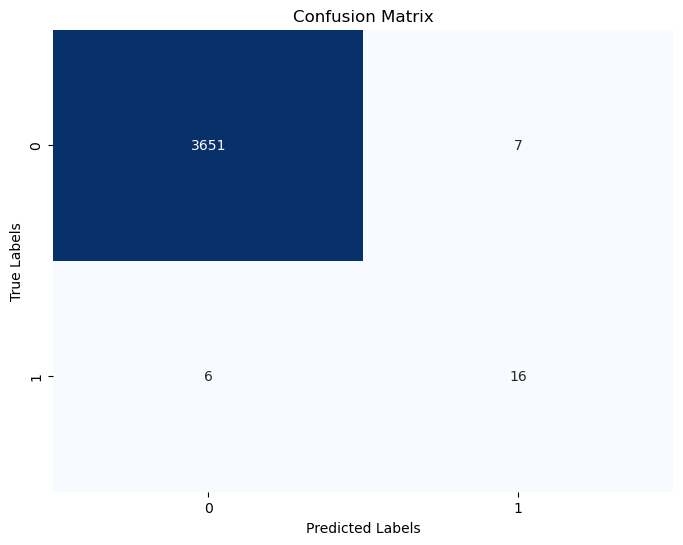

In [41]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [42]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform



# new
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_grid, 
                                   n_iter=10, scoring='precision', cv=5, random_state=42)

# Fit RandomizedSearchCV to the resampled data
random_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters (RandomizedSearchCV):", best_params)

Best Hyperparameters (RandomizedSearchCV): {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}


In [43]:
# Initialize XGBoost classifier with the best hyperparameters
best_xgb_classifier = random_search.best_estimator_



In [44]:
# Predict on the test set
y_pred_xgb = best_xgb_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9964673913043478


In [45]:
# Print classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3658
           1       0.73      0.73      0.73        22

    accuracy                           1.00      3680
   macro avg       0.86      0.86      0.86      3680
weighted avg       1.00      1.00      1.00      3680



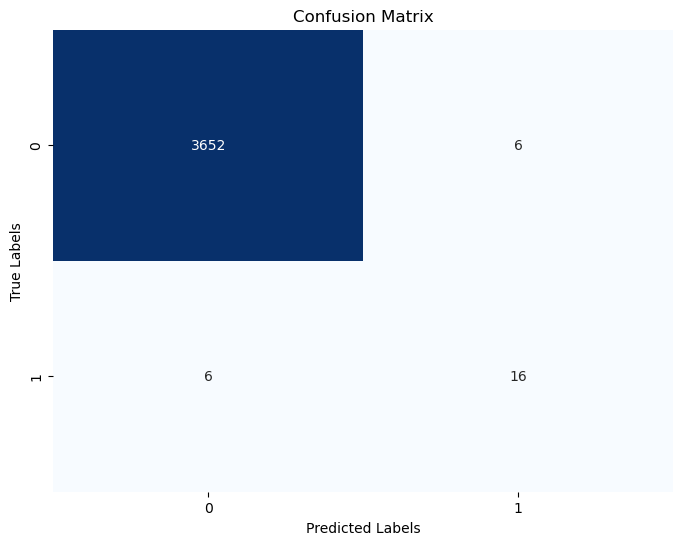

In [46]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [63]:
# import joblib

# # Save the model using joblib
# joblib.dump(best_xgb_classifier, 'best_xgb_classifier.joblib')

['best_xgb_classifier.joblib']

In [47]:
#Using 'csv' fprmat to store the data
# The first column is expected to be the ouput column

train_df.to_csv('train.csv', index=False, header=False)
test_df.to_csv('test.csv', index=False, header=False)

In [48]:
import sagemaker, boto3, os

bucket = sagemaker.Session().default_bucket()
prefix = "find-default-xgboost-credit-fraud"

boto3.Session().resource('s3').Bucket(bucket).Object(
        os.path.join(prefix,'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
        os.path.join(prefix,'data/test.csv')).upload_file('test.csv')

In [49]:
! aws s3 ls {bucket}/{prefix}/data --recursive

2024-04-02 18:00:08    2205893 find-default-xgboost-credit-fraud/data/test.csv
2024-03-30 23:51:13    1454835 find-default-xgboost-credit-fraud/data/test_data.csv
2024-04-02 18:00:07   17548792 find-default-xgboost-credit-fraud/data/train.csv
2024-03-30 23:51:13   11578613 find-default-xgboost-credit-fraud/data/train_data.csv


In [50]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

AWS Region: us-east-1
RoleArn: arn:aws:iam::632049544781:role/service-role/AmazonSageMaker-ExecutionRole-20240328T220415


In [51]:
sagemaker.__version__

'2.214.0'

In [52]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]

)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [53]:
xgb_model.set_hyperparameters(
    num_round=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth']
)

In [54]:
from sagemaker.session import TrainingInput

train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
test_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/test.csv"), content_type="csv"
)


In [55]:
xgb_model.fit({"train":train_input}, wait=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-04-02-18-00-10-735


2024-04-02 18:00:11 Starting - Starting the training job...
2024-04-02 18:00:35 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
...
2024-04-02 18:01:08 Downloading - Downloading input data......
2024-04-02 18:01:56 Downloading - Downloading the training image...
2024-04-02 18:02:39 Training - Training image download completed. Training in progress...[2024-04-02 18:02:47.941 ip-10-0-237-23.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[2024-04-02 18:02:48.138 ip-10-0-237-23.ec2.internal:7 INFO json_config.py:91] Creating hook from json_config at /opt/ml/input/config

In [56]:
rule_ouput_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.name +"/rule-ouput"
! aws s3 ls {rule_output_path} --recursive


Parameter validation failed:
Invalid bucket name "{rule_output_path}": Bucket name must match the regex "^[a-zA-Z0-9.\-_]{1,255}$" or be an ARN matching the regex "^arn:(aws).*:(s3|s3-object-lambda):[a-z\-0-9]*:[0-9]{12}:accesspoint[/:][a-zA-Z0-9\-.]{1,63}$|^arn:(aws).*:s3-outposts:[a-z\-0-9]+:[0-9]{12}:outpost[/:][a-zA-Z0-9\-]{1,63}[/:]accesspoint[/:][a-zA-Z0-9\-]{1,63}$"


In [57]:
! aws s3 cp {rule_ouput_path} ./ --recursive

In [58]:
xgb_model.model_data

's3://sagemaker-us-east-1-632049544781/find-default-xgboost-credit-fraud/xgboost_model/sagemaker-xgboost-2024-04-02-18-00-10-735/output/model.tar.gz'

In [59]:
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
   initial_instance_count=1,
   instance_type='ml.t2.medium',
   serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-04-02-18-04-58-316
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-04-02-18-04-58-316
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-04-02-18-04-58-316


--------------!

In [60]:
# Initialize the SageMaker runtime client
sagemaker_runtime = boto3.client('sagemaker-runtime')
# Specify the endpoint name
endpoint_name = xgb_predictor.endpoint_name  

In [61]:
# Iterate through test data and invoke endpoint for predictions
predictions = []
for index, row in X_test.iterrows():
    payload = ','.join(map(str, row.values))
    response = sagemaker_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                                 ContentType='text/csv',
                                                 Body=payload)
    result = response['Body'].read().decode('utf-8')
    predictions.append(float(result.strip()))



In [62]:
# Delete the endpoint
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
print(f"Endpoint {endpoint_name} is successfully deleted.")

Endpoint sagemaker-xgboost-2024-04-02-18-04-58-316 is successfully deleted.
